Counter({1: 100, 0: 45})
Counter({0: 100, 1: 100})


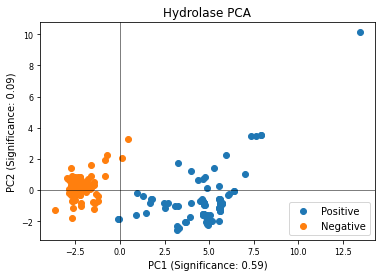

In [2]:
from Bio import SeqIO
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
from numpy import where
from sklearn.preprocessing import StandardScaler

# Extrair os descritores
def extract_descriptors(sequence):
    descriptor = [len(sequence), sequence.count('A'), sequence.count('C'),
                  sequence.count('D'), sequence.count('E'), sequence.count('F'),
                  sequence.count('G'), sequence.count('H'), sequence.count('I'),
                  sequence.count('K'), sequence.count('L'), sequence.count('M'),
                  sequence.count('N'), sequence.count('P'), sequence.count('Q'),
                  sequence.count('R'), sequence.count('S'), sequence.count('T'),
                  sequence.count('V'), sequence.count('W'), sequence.count('Y')]
    return descriptor

# Construir o dataframe
def create_dataframe(positive_file, negative_file):
    positive_sequences = list(SeqIO.parse(positive_file, 'fasta'))
    negative_sequences = list(SeqIO.parse(negative_file, 'fasta'))

    sequences = positive_sequences + negative_sequences
    labels = [0] * len(positive_sequences) + [1] * len(negative_sequences)
    descriptors = [extract_descriptors(str(seq.seq)) for seq in sequences]

    df = pd.DataFrame({'Label': labels, 'Descriptor': descriptors})
    return df


positive_file = '/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta'
negative_file = '/Users/Sergiomendes/Desktop/Project/data/notPET.fasta'

df = create_dataframe(positive_file, negative_file)

# Normalização dos dados
scaler = StandardScaler()
descriptors = df['Descriptor'].values.tolist()
descriptors_scaled = scaler.fit_transform(descriptors)

# Executar PCA
pca = PCA(n_components=2)  # Set n_components to 2
pca_result = pca.fit_transform(descriptors_scaled)

# Adicionar os resultados ao dataframe
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

# Extrair os valores de significância
explained_variance_ratio = pca.explained_variance_ratio_

# Extrair features e labels
X = df[['PC1', 'PC2']].values
y = df['Label'].values

# Sumarizar a distribuição de classes
counter = Counter(y)
print(counter)

# Aplicar SMOTE de modo a gerar amostras sintéticas para os casos negativos
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Sumarizar a nova distribuição de classes
counter = Counter(y_resampled)
print(counter)

# Mapeamento das labels para as legendas desejadas
label_legend_mapping = {0: 'Positive', 1: 'Negative'}

# Visualizar o gráfico de dispersão 
for label, _ in counter.items():
    row_ix = where(y_resampled == label)[0]
    plt.scatter(X_resampled[row_ix, 0], X_resampled[row_ix, 1], label=label_legend_mapping[label])

# Título
plt.title('Hydrolase PCA')

# Legenda do eixo X
plt.xlabel('PC1')
plt.xticks(fontsize=8)

# Legenda do eixo Y
plt.ylabel('PC2')
plt.yticks(fontsize=8)

# Eixos X e Y
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Adicionar os valores de significância nos eixos
plt.xlabel(f'PC1 (Significance: {explained_variance_ratio[0]:.2f})')
plt.xticks(fontsize=8)
plt.ylabel(f'PC2 (Significance: {explained_variance_ratio[1]:.2f})')
plt.yticks(fontsize=8)
plt.legend()

plt.show()
